# Immersion Window Comparison - H2O

### Imports

In [216]:
import h2o
from h2o.estimators import H2ODeepLearningEstimator
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 mins 11 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_alexzamar_rkp6o3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.80 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


### Build, train, and cross-validate models

In [96]:
files = glob.glob('../Data/Reduced/IMM*.csv')

for f in files:
    # Load data
    data = h2o.import_file(f, header=1)
    data['Dive'] = data['Dive'].asfactor()
    data['BirdID'] = data['BirdID'].asfactor()
    
    # Extract model ID from filepath
    wdw = re.search(r"/IMM(\d+)_reduced", f).group(1)
    idd = 'IMM_window_' + wdw
    
    # Build and train the model:
    dl_cross = H2ODeepLearningEstimator(model_id = idd,
                                        distribution = "bernoulli",
                                        hidden = [200, 200],
                                        fold_column = 'BirdID',
                                        keep_cross_validation_models = True,
                                        keep_cross_validation_fold_assignment = True,
                                        keep_cross_validation_predictions = True,
                                        score_each_iteration = True,
                                        epochs = 50,
                                        train_samples_per_iteration = -1,
                                        activation = "RectifierWithDropout",
                                        input_dropout_ratio = 0.2,
                                        hidden_dropout_ratios = [0.2, 0.2],
                                        single_node_mode = False,
                                        balance_classes = False,
                                        force_load_balance = False,
                                        seed = 23123,
                                        score_training_samples = 0,
                                        score_validation_samples = 0,
                                        stopping_rounds = 0)

    dl_cross.train(x = data.columns[1:-1],
                   y="Dive",
                   training_frame=data)
    
    # Save model
    h2o.save_model(model=dl_cross, path="../Data/Reduced/H2O_IMM_XVal_Models/", force=True)

Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%


### Evaluate models

In [10]:
# Retrieve file paths
models = glob.glob('../Data/Reduced/H2O_IMM_XVal_Models/*')
all_mets = pd.DataFrame(columns=['Accuracy', 'AUC', 'Sensitivity', 'Specificity'])

for mod_pth in models:
    
    wdw = re.match('.*?([0-9]+)$', mod_pth).group(1)  # window size
    
    #print(f'PROCESSING MODEL: {mod_pth}...')
    model = h2o.load_model(mod_pth)
    
    # Pull out X-validation metrics
    metrics = model.cross_validation_metrics_summary().as_data_frame()
    metrics.set_index('', inplace=True)
    metrics = metrics.astype(float)
    
    accuracy = metrics['mean']['accuracy']
    auc = metrics['mean']['auc']
    sensitivity = metrics['mean']['recall']
    specificity = metrics['mean']['specificity']
    
    all_mets.loc[wdw] = [accuracy, auc, sensitivity, specificity]

# Sort and show data
all_mets.sort_index(ascending=True, axis=0, inplace=True)
all_mets.index.name = 'Window (s)'
all_mets

,Accuracy,AUC,Sensitivity,Specificity
Window (s),,,,
120,0.899045,0.928940,0.904088,0.894647
180,0.912163,0.948984,0.945191,0.880581
240,0.920811,0.956735,0.945910,0.896549
300,0.924332,0.963748,0.958844,0.890825
480,0.920994,0.962822,0.971331,0.874496
600,0.923452,0.959010,0.970020,0.878939


### Plot

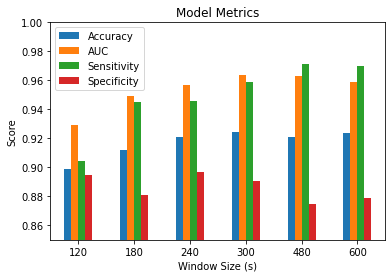

In [12]:
all_mets.plot.bar()

# Furnish plot
plt.xlabel("Window Size (s)")
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.ylim([0.85, 1.0])
plt.title('Model Metrics')

plt.show()

**CONCLUSION:** A window size of 300s (5 mins) attained the highest accuracy and AUC scores predicting dives from immersion data (0.924 and 0.964 respectively)